# Introduction to NLP Fundamentals in tensorflow for this project.

In this colab we'll be using a dataset from Kaggle that has text samples of Tweets labelled as diaster or not diaster.

The real Tweets are actually about disasters,  for example:


    Jetstar and Virgin forced to cancel Bali flights again because of ash from Mount Raung volcano*


The NOT real Tweets are Tweets not about disasters (they can be on anything), for example:


    'Education is the most powerful weapon which you can use to change the world.' Nelson #Mandela #quote


See the original source here: https://www.kaggle.com/c/nlp-getting-started/data.

## Imports and Helper Fuctions

```
!wget https://raw.githubusercontent.com/Charliecr94/Tensor_flow_projects/main/Extras/helper_functions.py
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

```

## Download a text dataset
```
# Download data.
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")
``` 



In [1]:
!wget https://raw.githubusercontent.com/Charliecr94/Tensor_flow_projects/main/Extras/helper_functions.py
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys
# Download data.
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2023-03-05 00:41:45--  https://raw.githubusercontent.com/Charliecr94/Tensor_flow_projects/main/Extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10234 (10.0K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.99K  --.-KB/s    in 0s      

2023-03-05 00:41:45 (55.8 MB/s) - ‘helper_functions.py’ saved [10234/10234]

--2023-03-05 00:41:57--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.128, 142.250.128.128, 142.251.6.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [ap

# 1. Get the Data ready

### Exploring the dataset.

In [2]:
import pandas as pd
import numpy as np
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("train.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
# Shuffle training datafram
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [4]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

Since we have Two target values, we're dealing with a **binary classification** problem. Where:
  * `1` = a real disaster Tweet
  * `2` = not a real disaster Tweet
 




In [5]:
# How many total samples?
len(train_df), len(test_df)

(7613, 7613)

### Visualize some random training examples:

In [6]:
import random 
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text","target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1 (real disaster)
Text:
Civilian casualties rise as Afghan war intensifies in 2015-- http://t.co/NnylXhInPx

---

Target: 1 (real disaster)
Text:
Stop the Annihilation of the Salt River Wild Horses! http://t.co/wVobVVtXKg via @Change

---

Target: 1 (real disaster)
Text:
Russian 'food crematoria' provoke outrage amid crisis famine memories http://t.co/O4xLjnaV8F

---

Target: 1 (real disaster)
Text:
Though serious #natural #disaster increased in #Japanjapan #Nuclear safety standard is far inferior to #US standard.#anonymous #Nytimes

---

Target: 0 (not real disaster)
Text:
I'm at Baan Thai / Tsunami Sushi in Washington DC https://t.co/Udp10FRXrL

---



### Splitting data into training and validation sets

In [7]:
from sklearn.model_selection import train_test_split

# Split training data into training and validation sets.
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                           train_df_shuffled["target"].to_numpy(),
                                                                           test_size= 0.1,
                                                                           random_state= 42)                                                                                                                                                

In [8]:
# Check the lengths
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

### Converting text data to numbers using tokenisation and embeddings.

In [9]:
# Find the average numbers of tokens (words) in the trainin tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [10]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Setup text vectorization variables
max_vocab_length = 10000
max_length = 15

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens= max_vocab_length, # how many words in the vocabulary
                                    standardize='lower_and_strip_punctuation',
                                    split="whitespace",
                                    ngrams=None,
                                    output_mode="int",
                                    output_sequence_length=max_length,
                                    pad_to_max_tokens= True)


To map our `TextVectorization` instance `text_vectorizer` to our data, we can call the `adapt()` method on it whilst passing it our training text.

In [11]:
# fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [12]:
# Create a sample sentences and tokenize it
sample_sentences = "There's a flood in my street!"
text_vectorizer([sample_sentences])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

Beautiful!

Now we've got a way to turn our text into numbers, so let's try this `text_vectorizer` instance on a few random training sentences!

In [13]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
I don't think I've forgiven Angelina Jolie yet sef????      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   8,   63,  125,  276, 3834,    1,    1,  522, 8689,    0,    0,
           0,    0,    0,    0]])>

Finally, we can check out some uniques tokens in our vocabulary using `get_vocabulary()` method

In [14]:
# Get the unique words in the vocabulary
words_in_vocabulary = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocabulary[:5]
bottom_5_words = words_in_vocabulary[-5:]
print(f"Number of words in vocab: {len(words_in_vocabulary)}")
print(f"Top 5 most common words:{top_5_words}")
print(f"Bottom 5 least common words:{bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words:['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words:['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

In [15]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             embeddings_initializer="uniform",
                             input_length=max_length,
                             name="embedding_1")
embedding


In [16]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
RT AbbsWinston: #Zionist #Terrorist demolish 18 #Palestinian structures in Jordan Valley http://t.co/rg3BndKXjX
Û_ http://t.co/Bq90pfzMrP      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.04330316,  0.03000936, -0.01007104, ..., -0.01782364,
         -0.04431009, -0.01077261],
        [ 0.03842631,  0.01592392, -0.04896264, ..., -0.02234856,
         -0.02458001, -0.00655719],
        [-0.04303288, -0.00162409,  0.03992632, ...,  0.03958665,
          0.0231748 , -0.01933272],
        ...,
        [-0.01410971,  0.0111716 , -0.02339493, ..., -0.01330055,
         -0.04998635, -0.0366699 ],
        [-0.00105945, -0.03160929, -0.04777439, ...,  0.04389774,
          0.00304613,  0.03793835],
        [-0.01440243,  0.01211596, -0.0374791 , ..., -0.03121144,
          0.01548835,  0.01455582]]], dtype=float32)>

Each token in the sentences gets turned into a length 128 feature vector.

So now the our data is ready let's test some models:

# Modeling a text dataset

In this colab we'll explore 7 modeling solutions.

  * **Model 0:** Naive Bayes (From Sklearn)
  * **Model 1:** Feed-forward neural network
  * **Model 2:** LSTM model (RNN)
  * **Model 3:** GRU model (RNN)
  * **Model 4:** Bidirectional-LSTM model (RNN)
  * **Model 5:** 1D Convolutional Neural Network (CNN)
  * **Model 6:** TensorFlow Hub Pretrained Feature Extrator (using transfer learning for NLP)
  * Model 7: Same as model 6 with 10% of training data.


### Model 0: Getting a baseline with Scikit-Learn

To create our baseline, we'll create a Scikit-Learn Pipeline using the TF-IDF (term frequency-inverse document frequency) formula to convert our words to numbers and then model them with the Multinomial Naive Bayes algorithm. This was chosen via referring to the [Scikit-Learn machine learning map.](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)



In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modeling pipeline
model_0= Pipeline([
                   ("tfidf", TfidfVectorizer()),
                   ("clf", MultinomialNB())
                   ])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [18]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"The model have a {baseline_score*100:.2f}% of accuracy")

The model have a 79.27% of accuracy


In [19]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

# Evaluating the models

### Creating an evaluation function for our model experiments.

Since we're going to be evaluating several models in the same way, let's create a helper function which takes and array of predictions and ground truth labels and computes the following:

* Accuracy
* Precision
* Recall
* F1-score


In [20]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  """

  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred)
  
  # Calaculate model precision, recall and f1-score
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results


In [21]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels, y_pred=baseline_preds)
baseline_results

{'accuracy': 0.7926509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [22]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results, 
                                new_model_results=model_1_results)

NameError: ignored

# Improve throught experimentation

### Model 1: A simple dense model.

In [23]:
# Create a tensorboard callback
from helper_functions import create_tensorboard_callback

# Create a directory to save tensoBoard logs
SAVE_DIR = "model_logs"

In [24]:
# Build model with the Functional API
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) # Lower the dimensionalty of the embedding
outputs = layers.Dense(1, activation="sigmoid")(x) # Create the output layer
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model



In [25]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer= tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [26]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [27]:
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20230305-004248
Epoch 1/5
215/215 [==============================] - 17s 56ms/step - loss: 0.6136 - accuracy: 0.6908 - val_loss: 0.5358 - val_accuracy: 0.7612
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4411 - accuracy: 0.8178 - val_loss: 0.4733 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3482 - accuracy: 0.8590 - val_loss: 0.4606 - val_accuracy: 0.7861
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2851 - accuracy: 0.8913 - val_loss: 0.4602 - val_accuracy: 0.7927
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2376 - accuracy: 0.9114 - val_loss: 0.4775 - val_accuracy: 0.7835


Let's check this model performance on the validation set

In [28]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4775 - accuracy: 0.7835


[0.47747257351875305, 0.7834645509719849]

In [29]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 [==============================] - 0s 2ms/step


(762, 1)

In [30]:
# Look at the firts 3 predictions
model_1_pred_probs[:8]

array([[0.36936933],
       [0.78002536],
       [0.9977659 ],
       [0.15691847],
       [0.12556477],
       [0.9446184 ],
       [0.91200566],
       [0.9925127 ]], dtype=float32)

For comparing our `pred_probs` with the `true_labels` we need to convert the predicts to label format.

In [31]:
# Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [32]:
# Calculate our model_1 results
model_1_results = calculate_results(y_true= val_labels,
                                    y_pred= model_1_preds)
model_1_results

{'accuracy': 0.7834645669291339,
 'precision': 0.7864953185428455,
 'recall': 0.7834645669291339,
 'f1': 0.7810537461695031}

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
#!tensorboard dev upload --logdir ./model_logs \
#   --name "First deep model on text data" \
#   --description "Trying a dense model with an embedding layer" \
#   --one_shot # exits the uploader when upload has finished

In [ ]:
# Delete Tensoboard instance.
#!tensorboard dev delete --experiment_id Y87inY29TPCA0nwXKXIkqg

Looks like our baseline is out performing our firts deep learning model...

### Model_2: LSTM RNN

To make sure we're not reusing trained embeddings, we'll create another embedding layer for our second model.

In [35]:
# Set random seed and create embedding layer
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length= max_length,
                                     name="embedding_2")

In [36]:
#  Set random seed and create embedding layer
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
x = layers.LSTM(64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2= tf.keras.Model(inputs,outputs, name="model_2_LSTM")

In [37]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [38]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [39]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                               train_labels,
                               epochs=5,
                               validation_data=(val_sentences, val_labels),
                               callbacks= [create_tensorboard_callback(SAVE_DIR,
                                                                       "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20230305-005158
Epoch 1/5
215/215 [==============================] - 15s 45ms/step - loss: 0.5086 - accuracy: 0.7463 - val_loss: 0.4578 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3171 - accuracy: 0.8713 - val_loss: 0.5094 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.2199 - accuracy: 0.9171 - val_loss: 0.5789 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1557 - accuracy: 0.9467 - val_loss: 0.6308 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1077 - accuracy: 0.9602 - val_loss: 0.9127 - val_accuracy: 0.7559


In [40]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10] # view the firts 10

24/24 [==============================] - 1s 5ms/step


((762, 1), array([[0.00942706],
        [0.71005934],
        [0.9994272 ],
        [0.04860404],
        [0.00222313],
        [0.9996648 ],
        [0.94955885],
        [0.9997416 ],
        [0.9996505 ],
        [0.41535503]], dtype=float32))

Our current model returns prediction probabilities rather than classes, we can turn these predictions into classes by rounding to the nearest integer.

In [41]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [42]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true= val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 0.7559055118110236,
 'precision': 0.756358217141213,
 'recall': 0.7559055118110236,
 'f1': 0.7542126125197939}

In [43]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 0.79, New accuracy: 0.76, Difference: -0.04
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.04
Baseline f1: 0.79, New f1: 0.75, Difference: -0.03


### Model_3: GRU RNN

In [44]:
# Create embedding layer
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")
# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
x = layers.GRU(64)(x) 
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [45]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [46]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [47]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data= (val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,"GRU")])

Saving TensorBoard log files to: model_logs/GRU/20230305-005223
Epoch 1/5
215/215 [==============================] - 13s 44ms/step - loss: 0.5251 - accuracy: 0.7310 - val_loss: 0.4573 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3186 - accuracy: 0.8675 - val_loss: 0.4894 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2183 - accuracy: 0.9184 - val_loss: 0.5578 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1564 - accuracy: 0.9448 - val_loss: 0.6223 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1196 - accuracy: 0.9588 - val_loss: 0.6067 - val_accuracy: 0.7730


In [48]:
# Make predictions on validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]


24/24 [==============================] - 1s 4ms/step


((762, 1), array([[0.30750743],
        [0.902441  ],
        [0.99634415],
        [0.16187859],
        [0.01427832],
        [0.9894365 ],
        [0.71724707],
        [0.99729925],
        [0.99620926],
        [0.52437747]], dtype=float32))

In [49]:
# Convert prediction probabilities to prediction classes
model_3_pred = tf.squeeze(tf.round(model_3_pred_probs))
model_3_pred[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [50]:
# Calculate model_3 results
model_3_results = calculate_results(y_true= val_labels,
                                    y_pred= model_3_pred)
model_3_results

{'accuracy': 0.7729658792650919,
 'precision': 0.7728481089662449,
 'recall': 0.7729658792650919,
 'f1': 0.7720634753279543}

In [51]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 0.79, New accuracy: 0.77, Difference: -0.02
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.01


### Model_4: Bidirectonal RNN.

In [52]:
# Create embedding layer
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a bidirectional RNN in Tensorflow
inputs = layers.Input(shape= (1,), dtype= "string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [53]:
# Get a summary
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [54]:
# Compile model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [55]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data = (val_sentences, val_labels),
                              callbacks= [create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20230305-005248
Epoch 1/5
215/215 [==============================] - 16s 51ms/step - loss: 0.5090 - accuracy: 0.7469 - val_loss: 0.4591 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3118 - accuracy: 0.8751 - val_loss: 0.5288 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.2096 - accuracy: 0.9212 - val_loss: 0.5734 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1419 - accuracy: 0.9517 - val_loss: 0.6430 - val_accuracy: 0.7822
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0994 - accuracy: 0.9651 - val_loss: 0.7195 - val_accuracy: 0.7677


In [56]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 4ms/step


array([[0.03013844],
       [0.8001734 ],
       [0.9995055 ],
       [0.14416444],
       [0.00202807],
       [0.99730694],
       [0.91770506],
       [0.9996495 ],
       [0.99949443],
       [0.19597304]], dtype=float32)

In [57]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [58]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 0.7677165354330708,
 'precision': 0.7679905783589133,
 'recall': 0.7677165354330708,
 'f1': 0.7663871505080737}

In [59]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 0.79, New accuracy: 0.77, Difference: -0.02
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


 ### Model_5: Conv1D

In [60]:
from tensorflow.keras import layers

model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")
# Create 1-dimensional convolutional layer to model sequence.
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1,activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D
model_5.compile(loss="binary_crossentropy",
                optimizer= tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 1)              

In [61]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20230305-005335
Epoch 1/5
215/215 [==============================] - 14s 38ms/step - loss: 0.2282 - accuracy: 0.9114 - val_loss: 0.5517 - val_accuracy: 0.7927
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1732 - accuracy: 0.9327 - val_loss: 0.6432 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1352 - accuracy: 0.9486 - val_loss: 0.6902 - val_accuracy: 0.7822
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1066 - accuracy: 0.9600 - val_loss: 0.7728 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0829 - accuracy: 0.9692 - val_loss: 0.8825 - val_accuracy: 0.7795


In [62]:
# Make some predictions with our Conv1D model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[5.8327073e-01],
       [6.1110717e-01],
       [9.9996686e-01],
       [2.8015751e-02],
       [1.6865013e-05],
       [9.9583483e-01],
       [9.9903595e-01],
       [9.9951601e-01],
       [9.9994648e-01],
       [5.3710127e-01]], dtype=float32)

In [63]:
# Convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [64]:
# Evaluate model 5 predictions
model_5_results = calculate_results(y_true= val_labels,
                                    y_pred= model_5_preds)

model_5_results

{'accuracy': 0.7795275590551181,
 'precision': 0.7816545659065345,
 'recall': 0.7795275590551181,
 'f1': 0.7774022539420016}

In [65]:
# Compare model_5 results to baseline
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 0.79, New accuracy: 0.78, Difference: -0.01
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


### Model_6: Transfer learning for NLP.

In this oportunity, we're going to be using the Universal Sentences Enconder from Tensorflow Hub.

In [66]:
sample_sentence= "There's a flood in my street!"

In [67]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50]), embed_samples.shape

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


(None, TensorShape([2, 512]))

Passing our sentences to the Universal Sentence Encoder (USE) encodes them from strings to 512 dimensional vectors, which make no sense to us but hopefully make sense to our machine learning models.

In [68]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE") 

In [69]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1,activation="sigmoid")
], name = "model_6_USE")

# Compile the model
model_6.compile(loss="binary_crossentropy",
                optimizer= tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [70]:
# Train a classifier on top of Use pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20230305-005421
Epoch 1/5
215/215 [==============================] - 8s 19ms/step - loss: 0.5028 - accuracy: 0.7853 - val_loss: 0.4468 - val_accuracy: 0.7953
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4149 - accuracy: 0.8152 - val_loss: 0.4350 - val_accuracy: 0.8123
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3997 - accuracy: 0.8231 - val_loss: 0.4305 - val_accuracy: 0.8136
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3920 - accuracy: 0.8266 - val_loss: 0.4258 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.3854 - accuracy: 0.8302 - val_loss: 0.4271 - val_accuracy: 0.8150


In [71]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]
model_6_pred_probs.shape

24/24 [==============================] - 1s 10ms/step


(762, 1)

In [72]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:5]


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 1., 0., 1.], dtype=float32)>

In [73]:
# Calculate model 6 perfomance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 0.8149606299212598,
 'precision': 0.8179063565195398,
 'recall': 0.8149606299212598,
 'f1': 0.8132300658103407}

In [74]:
# Compate TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 0.79, New accuracy: 0.81, Difference: 0.02
Baseline precision: 0.81, New precision: 0.82, Difference: 0.01
Baseline recall: 0.79, New recall: 0.81, Difference: 0.02
Baseline f1: 0.79, New f1: 0.81, Difference: 0.03


### Model_7: TensorFlow Hub Pretrained Feature Extracture (10% of data)

In [75]:
# Create subsets of 10% of the training data
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)

In [76]:
# Check length of 10 percent datasets
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10% training examples: 686


In [77]:
# Clone model_6
model_7 = tf.keras.models.clone_model(model_6)

# Compile model_7
model_7.compile(loss="binary_crossentropy",
                optimizer= tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [78]:
# Fit the model to 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data= (val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20230305-005451
Epoch 1/5
22/22 [==============================] - 5s 48ms/step - loss: 0.6728 - accuracy: 0.6910 - val_loss: 0.6552 - val_accuracy: 0.6903
Epoch 2/5
22/22 [==============================] - 1s 23ms/step - loss: 0.6054 - accuracy: 0.8076 - val_loss: 0.6005 - val_accuracy: 0.7362
Epoch 3/5
22/22 [==============================] - 1s 24ms/step - loss: 0.5294 - accuracy: 0.8251 - val_loss: 0.5452 - val_accuracy: 0.7598
Epoch 4/5
22/22 [==============================] - 1s 27ms/step - loss: 0.4630 - accuracy: 0.8353 - val_loss: 0.5106 - val_accuracy: 0.7651
Epoch 5/5
22/22 [==============================] - 1s 24ms/step - loss: 0.4175 - accuracy: 0.8426 - val_loss: 0.4920 - val_accuracy: 0.7730


In [79]:
# Make predictions wit the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:5]

24/24 [==============================] - 1s 10ms/step


array([[0.27574942],
       [0.80887794],
       [0.8949982 ],
       [0.3226107 ],
       [0.5698874 ]], dtype=float32)

In [80]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 1., 0., 1.], dtype=float32)>

In [81]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 0.7729658792650919,
 'precision': 0.7774632689285239,
 'recall': 0.7729658792650919,
 'f1': 0.7696944315968833}

In [82]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results,model_7_results)

Baseline accuracy: 0.79, New accuracy: 0.77, Difference: -0.02
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


## Comparing the perfomance of each of our models.

In [83]:
# Combine model results into a Dataframe
all_model_results = pd.DataFrame ({"baseline": baseline_results,
                                   "1_simple_dense": model_1_results,
                                   "2_ltsm":  model_2_results,
                                   "3_gru": model_3_results,
                                   "4_bidirectional": model_4_results,
                                   "5_Conv1D": model_5_results,
                                   "6_tf_hub_use_encoder": model_6_results,
                                   "7_tf_hub_use_enconder_10_percent": model_7_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.783465,0.786495,0.783465,0.781054
2_ltsm,0.755906,0.756358,0.755906,0.754213
3_gru,0.772966,0.772848,0.772966,0.772063
4_bidirectional,0.767717,0.767991,0.767717,0.766387
5_Conv1D,0.779528,0.781655,0.779528,0.777402
6_tf_hub_use_encoder,0.814961,0.817906,0.814961,0.813230
7_tf_hub_use_enconder_10_percent,0.772966,0.777463,0.772966,0.769694


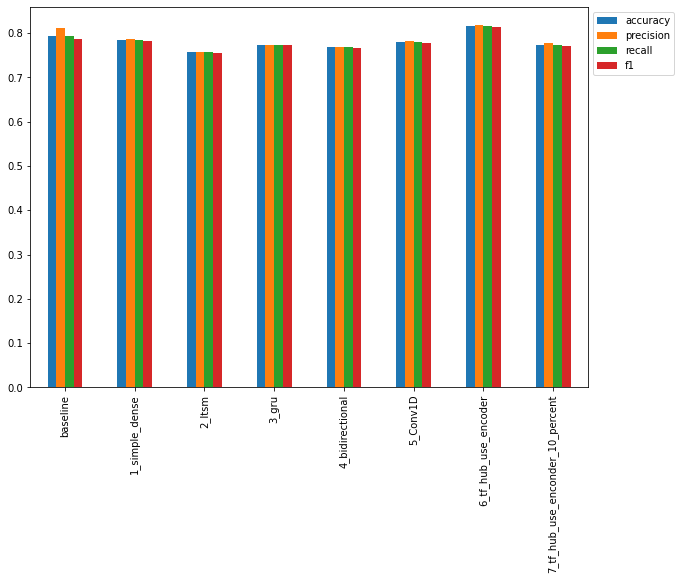

In [84]:
 # Plot and compare all of the model results
 all_model_results.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1,1));

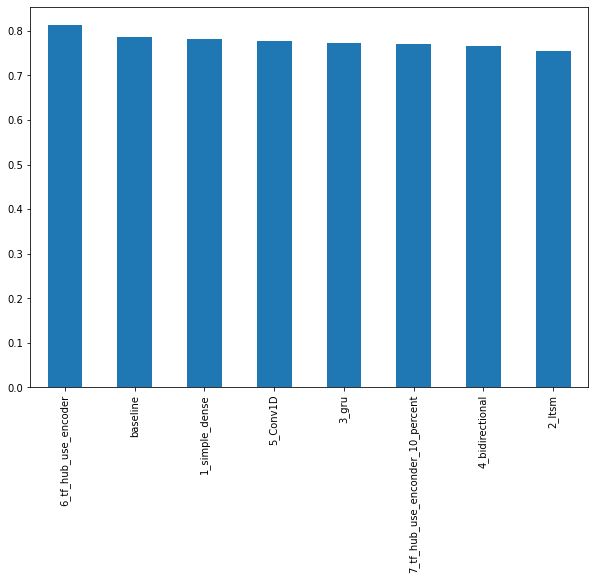

In [85]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7));

Since all our models experiments are reaching to similars results, maybe it's a good idea to return to the data and figure out why is these happening. But firts let's visualize the Tensoboard callbacks and save the best model

## Uploading our model training logs to TensorBoard.Dev

In [86]:
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records

#!tensorboard dev upload --logdir ./model_logs \
#  --name "NLP modelling experiments" \
# --description "A series of different NLP modellings experiments with various models" \
#--one_shot # exits the uploader when upload has finished

In [87]:
# If you need to remove previous experiments, you can do so using the following command
#!tensorboard dev delete --experiment_id kEomHmGfR6Oo01tnt9OBbg

# Save the best model

In [88]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

In [89]:
# Load model with custom Hub Layer (required with HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5", 
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [90]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 19ms/step - loss: 0.4271 - accuracy: 0.8150


[0.42707163095474243, 0.8149606585502625]

## Finding the most wrong Examples
In this section we going to explore where our model is gretting wrong.

One of the best ways to inspect the data is to sort your model's predictions and find the samples it got most wrong, meaning, what predictions had a high prediction probability but turned out to be wrong.

In [91]:
# Create DataFrame with validation sentences and best performing model predictions.
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.157498
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.743334
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.987637
3,@camilacabello97 Internally and externally scr...,1,0.0,0.197110
4,Radiation emergency #preparedness starts with ...,1,1.0,0.742285


Now we'll filter this dataframe with only the wrong predictions (where target != pred) and sort them by their prediction probability.

In [92]:
# Find the wrong predictions and sort by prediction probabilities.
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending= False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.916003
628,@noah_anyname That's where the concentration c...,0,1.0,0.855746
759,FedEx will no longer transport bioterror patho...,0,1.0,0.855002
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.851727
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.833641
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.810274
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.788421
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.784474
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.771382
144,The Sound of Arson,0,1.0,0.760912


In [93]:
# Check the false positivies (model predicted 1 when should've been 0)
for row in most_wrong[10:].itertuples():
 _, text, target, pred,pred_prob = row 
 print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
 print(f"Text:\n {text} \n")
 print("---\n")

Target: 0, Pred: 1.0, Prob: 0.7442207932472229
Text:
 A look at state actions a year after Ferguson's upheaval http://t.co/GZEkQWzijq 

---

Target: 0, Pred: 1.0, Prob: 0.7433338761329651
Text:
 FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday 

---

Target: 0, Pred: 1.0, Prob: 0.7380508184432983
Text:
 Deaths 3 http://t.co/nApviyGKYK 

---

Target: 0, Pred: 1.0, Prob: 0.7344895601272583
Text:
 @RebeccaforReal accepts Wisconsin Emergency Response Plan on behalf of @GovWalker #nbc15 http://t.co/Pis0aiVRbR 

---

Target: 0, Pred: 1.0, Prob: 0.7189075350761414
Text:
 Day 2. Liquidation of emergency at chemical object. #USAR2015 #USAR15 #RUOR #??????????? http://t.co/gGTmDqUdDo 

---

Target: 0, Pred: 1.0, Prob: 0.7177956104278564
Text:
 @freefromwolves GodsLove &amp; #thankU brother Danny for RT of NEW VIDEO http://t.co/cybKsXHF7d The Coming Apocalyptic US Earthquake &amp; Tsunami 

---

Target: 0, Pred: 1.0, Prob: 0.70825552

It seems like we had a couple of issues with our labeling, the most frequent wrong prediction occurs because the labeling isn't correct.

### Making predictions on the test dataset

In [94]:
# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

1/1 [==============================] - 0s 51ms/step
Pred: 1, Prob: 0.8488827347755432
Text:
Rainstorm downtown Gloucester
#gloucester #capeann #seagulls #triciaoneill #triciaoneillphoto https://t.co/oLS6qdi9Um

----

1/1 [==============================] - 0s 39ms/step
Pred: 0, Prob: 0.21186095476150513
Text:
? Cracker - White Riot ? http://t.co/Cc7D0wxk0M #nowplaying

----

1/1 [==============================] - 0s 39ms/step
Pred: 0, Prob: 0.07202401757240295
Text:
Got in a car wreck. The car in front of me didn't put their blinker on :-))) but it really does feel great outside so lol

----

1/1 [==============================] - 0s 42ms/step
Pred: 1, Prob: 0.8660120964050293
Text:
Sinkhole Disrupts Downtown Trolley Service #SanDiego - http://t.co/9tb82ZMr2X

----

1/1 [==============================] - 0s 40ms/step
Pred: 0, Prob: 0.1166166365146637
Text:
@EBROINTHEAM jay....big L....pun....biggie...wrap over...zero question....fatality...flawless victory http://t.co/Y33QcKq7qD

----



On the useen data our model seems mush better than his stats reflects, that is because sometimes a Tweet context is hard to figure out across himself.

# Predicting on Tweets from the jungle of twitter.
How about we find some Tweets and use our model to predict whether or not they're about a diaster or not?

In [111]:
# Turn the Tweet into string.
mister_seitan_tweet = "Forbidden to forget \"where it comes from\", because the tricksters will try to make people forget soon."
juan_ramon_tweet = "The second edition of Anti-Marx is already arriving in bookstores"
elon_musk_tweet = "Something should be done"
elon_musk_tweet_2 = "169 mT to orbit this year so far"


In [100]:
# Small fuction for taking our model and made a prediction 
def predict_on_sentences(model,sentence):
  """
  Returns the sentences, the predicted label and the prediction probability
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [110]:
# Make a prediction on our tweet
predict_on_sentences(model=model_6, 
                     sentence=mister_seitan_tweet)

predict_on_sentences(model=model_6,
                     sentence=juan_ramon_tweet)

predict_on_sentences(model=model_6,
                     sentence=elon_musk_tweet)

predict_on_sentences(model=model_6,
                     sentence=elon_musk_tweet_2)


1/1 [==============================] - 0s 39ms/step
Pred: 0.0 (not real disaster) Prob: 0.11294422298669815
Text:
Forbidden to forget "where it comes from", because the tricksters will try to make people forget soon.
1/1 [==============================] - 0s 46ms/step
Pred: 0.0 (not real disaster) Prob: 0.07895895838737488
Text:
The second edition of Anti-Marx is already arriving in bookstores
1/1 [==============================] - 0s 44ms/step
Pred: 0.0 (not real disaster) Prob: 0.26078373193740845
Text:
Something should be done
1/1 [==============================] - 0s 41ms/step
Pred: 0.0 (not real disaster) Prob: 0.10574204474687576
Text:
169 mT to orbit this year so far


Beautiful ! Our model predicte correctly 4 times a row!

Now let's try with some disasters tweets

In [112]:
# Source - https://twitter.com/BeirutCityGuide/status/1290696551376007168
beirut_tweet_1 = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"

# Source - https://twitter.com/BeirutCityGuide/status/1290773498743476224
beirut_tweet_2 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"

In [114]:
# Predict on diaster Tweet 1
predict_on_sentences(model=model_6, 
                    sentence=beirut_tweet_1)

# Predict on diaster Tweet 2
predict_on_sentences(model=model_6, 
                    sentence=beirut_tweet_2)

1/1 [==============================] - 0s 72ms/step
Pred: 1.0 (real disaster) Prob: 0.9609401822090149
Text:
Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon
1/1 [==============================] - 0s 73ms/step
Pred: 1.0 (real disaster) Prob: 0.9706016182899475
Text:
#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon


Wubba lubba dub-dub, both results are correct!

# Speed/score tradeoff of our project

In [96]:
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  """
  start_time = time.perf_counter()
  model.predict(samples)
  end_time = time.perf_counter()
  total_time = end_time-start_time
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [97]:
# Calculate TF Hub Sentence Enconder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6,
                                                            samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 10ms/step


(0.3641844440001023, 0.00047793234120748336)

In [98]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.05231427100011388, 6.865389895028068e-05)

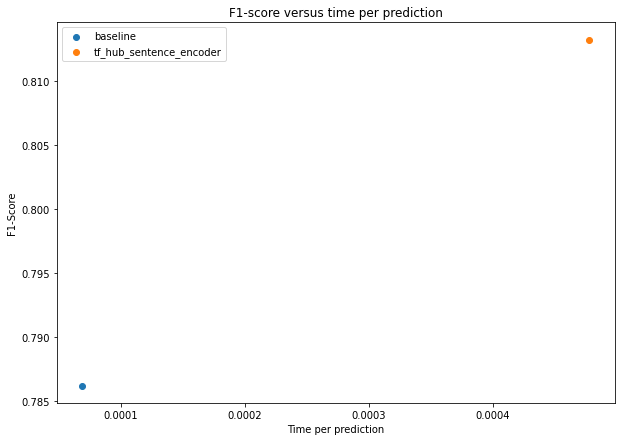

In [99]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");